In [192]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import logging
from scipy.optimize import curve_fit
from argparse import ArgumentParser
import json
import os
import sys
from bokeh.plotting import figure, show
from bokeh.models import Span, Legend, LegendItem, ColorBar, LinearColorMapper
from bokeh.io import output_notebook
import panel as pn
from scipy.stats import gaussian_kde
output_notebook()

Loading BokehJS ...

In [19]:
# Hutches that support jet tracking
HUTCHES = [
    'cxi',
    'mfx'
]

DETS = [
    'DsaCsPad',
    'DsbCsPad',
    'DscCsPad'
]

# The possible intensity monitors to use, prefer f_2.. since
# this is after the solid attenuators (maybe still true?)
# TODO: find wave8 key and add to I_MONS
I_MONS = [
    'f_11_ENRC',
    'f_12_ENRC',
    'f_21_ENRC',
    'f_22_ENRC',
    'f_63_ENRC',
    'f_64_ENRC'
]

# base path to experiment data
DATA_PATH = '/reg/d/psdm/'

# extension to small data hdf5 files
HDF5_EXT = '/hdf5/smalldata/'

# Calib directory to write results to
CAL_DIR = '/calib/'
CAL_FILE = 'jt_cal'

# dataset keys
GDET_KEY = 'gas_detector'
AZAV_KEY = 'azav_azav'

# Guassian Fitting
LINE_FIT_POINTS = 50
RADIAL_RANGE = 5

# Lower bound on peak values
PK_LOW = 5

# Logger
f = '%(asctime)s - %(levelname)s - %(filename)s:%(funcName)s - %(message)s'
logging.basicConfig(level=logging.DEBUG, format=f)
logger = logging.getLogger(__name__)

In [3]:
def gaussian(x, a, mean, std, m, b):
    """Equation for gaussian with linear component/offset"""
    return (a * np.exp(-((x - mean) / 2 / std) ** 2)) + (m * x + b)

def fit_line(array, fit_points=LINE_FIT_POINTS):
    """Fit the line from edges of array"""
    azav_len = len(ave_azav)
    x0 = fit_points / 2
    x1 = azav_len - (fit_points / 2)
    y0 = np.mean(ave_azav[:fit_points])
    y1 = np.mean(ave_azav[azav_len - fit_points:])
    m, b = np.polyfit((x0, x1), (y0, y1), 1)

    return m, b

def peak_lr(array_data, threshold=0.05, bins=100):
    """Find max of normal distribution from histogram, search right and left until
    population falls below threshold
    """
    hist, edges = np.histogram(array_data, bins=bins)
    
    # Find peak information
    peak_val = hist.max()
    peak_idx = np.where(hist == peak_val)[0][0]
    peak_bin = edges[peak_idx]
    
    #search right
    right = np.argmax(hist[peak_idx:] < threshold * peak_val)
    right += peak_idx
    
    # search left
    left_array = hist[:peak_idx]
    left = peak_idx - np.argmax(left_array[::-1] < threshold * peak_val)
    
    return hist, edges, peak_idx, left, right

def det_azav(f, idxs_use):
    """Get the average azimuthally q binned array from used events"""
    # Find the detector term
    shared_det = set(DETS).intersection(f.keys())
    if not bool(shared_det):
        raise ValueError('smalldata file does not contain known detector')

    # Assuming they didn't have two different detector keys...
    det = shared_det.pop()
    logger.debug(f'Getting azimuthal values for detector: {det}')
    det_group = f[det]
    azav = np.array(det_group[AZAV_KEY])
    azav_use = azav[idxs_use]
    ave_azav = (azav_use.sum(axis=0) / len(azav_use))[0]
    logger.debug('Found azimuthal average arrays for all used events')

    return azav_use, ave_azav

def integrated_intensity(ave_azav, median_intensity, delta_bin=RADIAL_RANGE):
    """Fit the gaussian with linear offset and get the peak 
    and integrated intensity around peak
    """
    logger.debug('Fitting Guassian of average azimuthal binned array')
    azav_len = len(ave_azav)
    # Fit the line
    m, b = fit_line(ave_azav)

    # Estimate mean and std
    x = np.arange(azav_len)
    mean = sum(x * ave_azav) / sum(ave_azav)
    std = np.sqrt(sum((x - mean) ** 2 / azav_len))

    # Fit Gaussian and get center and integrated intensity
    popt, _ = curve_fit(gaussian, x, ave_azav, p0=[max(ave_azav), mean, std, m, b])
    peak = int(round(popt[1]))
    bin_start = peak - delta_bin
    bin_end = peak + delta_bin
    integrated_intensity = round(ave_azav[rad_start:rad_end].sum(axis=0) / median_intensity, 2)
    logger.debug(f'Peak found at {peak}, with integrated intensity of {integrated_intensity}') 

    return peak, integrated_intensity, bin_start, bin_end

def peak_in_bins(azav_use, peak, i0_data, left_bin, right_bin):
    """Get the peak in the bins we're using"""
    peak_vals = np.array([azav[0][low:hi].sum(axis=0) for azav in azav_use])
    peak_idxs = np.where(peak_vals > low_limit)
    peak_vals = peak_vals[peak_idxs]
    ratio = peak_vals.mean() / i_dat.mean()

    return peak_vals, peak_idxs, ratio

def fit_limits(intensity, peak_vals, edges):
    m, b = np.polyfit(intensity, peak_vals, 1)
    x = np.arange(edges[0], edges[-1], 0.1)
    sigma = np.std(peak_vals)
    y = x * m + b
    
    return x, y, m, b, sigma

def peak_fig(signal, hist, edges, peak_idx, left, right):
    """General histogram plotter with peak location and left/right limits plotted"""
    fig = figure(
        title=f'Used Intensity Distribution for {signal}. Low/Hi: {round(edges[left], 2)}/{round(edges[right], 2)}',
        x_axis_label='Intensity Values',
        y_axis_label='Counts'
    )
    fig.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:])
    left_line = Span(location=edges[left], dimension='height', line_color='black')
    right_line = Span(location=edges[right], dimension='height', line_color='black')
    peak_line = Span(location=edges[peak_idx], dimension='height', line_color='red')
    fig.renderers.extend([left_line, right_line, peak_line])
    
    return fig

def azav_fig(ave_azav, peak_bin, intensity, bin_start, bin_end):
    """Generate the azav fig for html file"""
    x_vals = np.arange(len(ave_azav))
    fig = figure(
        title=f'Average Azimuthal Binned Array: Center - {peak_bin}, min/max - {bin_start}/{bin_end}, integrated_intensity - {round(intensity, 2)}',
        x_axis_label='Bins',
        y_axis_label='Intensity',
    )

    peak_line = Span(location=peak, dimension='height', line_color='green', line_width=2)
    lower_line = Span(location=rad_start, dimension='height', line_color='black')
    upper_line = Span(location=rad_end, dimension='height', line_color='black')
    ave_azav_curve = fig.scatter(x_vals, ave_azav)
    fig.renderers.extend([peak_line, lower_line, upper_line])

    azav_legend = Legend(items=[
        LegendItem(label='Azimuthal Average', renderers=[ave_azav_curve])
    ])
    fig.add_layout(azav_legend)

    return fig

In [219]:
# Experiment and run to analyze, load hdf5 file
exp = 'cxilr6716'
run = '139'
hutch = exp[:3]
logger.debug(f'analyzing experiment {exp}, run number {run}')
exp_path = f'{DATA_PATH}{hutch}/{exp}'
sd_file = f'{exp_path}{HDF5_EXT}{exp}_Run{run}.h5'
f = h5py.File(sd_file, 'r')
logger.debug(f'loaded file with keys {f.keys()}')
i_mon = 'f_21_ENRC'

# Handle intensity data
i0_data = np.array(f[GDET_KEY][i_mon])
i0_data = np.nan_to_num(i_dat, copy=False)
i0_hist, i0_edges, i0_peak_idx, i0_left_idx, i0_right_idx = peak_lr(i0_data)

# Handle azav binned data
shared_det = set(DETS).intersection(f.keys())
if not bool(shared_det):
    raise ValueError('smalldata file does not contain known detector')

# Assuming they didn't have two different detector keys...
det = shared_det.pop()
logger.debug(f'Getting azimuthal values for detector: {det}')
det_group = f[det]
azav_data = np.array(det_group[AZAV_KEY])
ave_azav = (azav_data.sum(axis=0) / len(azav_data))[0]
azav_hist, azav_edges, azav_peak_idx, azav_left_idx, azav_right_idx = peak_lr(azav_data)
azav_intensity = np.array([azav_data[0][azav_left_idx:azav_right_idx].sum(axis=0) \
                           for azav in azav_use])


2020-06-25 09:52:40,151 - DEBUG - <ipython-input-219-0533571a5e92>:<module> - analyzing experiment cxilr6716, run number 139
2020-06-25 09:52:40,271 - DEBUG - <ipython-input-219-0533571a5e92>:<module> - loaded file with keys <KeysViewHDF5 ['DsaCsPad', 'KbEncoder', 'UserDataCfg', 'damage', 'ebeam', 'epicsUser', 'event_time', 'evr', 'fiducials', 'gas_detector', 'lightStatus', 'phase_cav', 'scan']>


In [125]:
# Find upper and lower limits for intensity monitor
hist_peak, edges_peak, peak_idx, left_peak, right_peak = peak_lr(i_dat)
show(peak_fig(i_mon, hist_peak, edges_peak, peak_idx, left_peak, right_peak))

In [128]:
# Filter on azimuthally binned array
def det_azav(f, idxs_use):
    """Get the average azimuthally q binned array from used events"""
    # Find the detector term
    shared_det = set(DETS).intersection(f.keys())
    if not bool(shared_det):
        raise ValueError('smalldata file does not contain known detector')

    # Assuming they didn't have two different detector keys...
    det = shared_det.pop()
    logger.debug(f'Getting azimuthal values for detector: {det}')
    det_group = f[det]
    azav = np.array(det_group[AZAV_KEY])
    azav_use = azav[idxs_use]
    ave_azav = (azav_use.sum(axis=0) / len(azav_use))[0]
    logger.debug('Found azimuthal average arrays for all used events')

    return azav_use, ave_azav
    
def calc_peak_and_intensity(ave_azav, i_dat, median_intensity):
    """Fit the gaussian with linear offset and get the peak 
    and integrated intensity around peak
    """
    logger.debug('Fitting Guassian of average azimuthal binned array')
    azav_len = len(ave_azav)
    # Fit the line
    m, b = fit_line(ave_azav)

    # Estimate mean and std
    x = np.arange(azav_len)
    mean = sum(x * ave_azav) / sum(ave_azav)
    std = np.sqrt(sum((x - mean) ** 2 / azav_len))

    # Fit Gaussian and get center and integrated intensity
    popt, _ = curve_fit(gaussian, x, ave_azav, p0=[max(ave_azav), mean, std, m, b])
    peak = int(round(popt[1]))
    rad_start = peak - RADIAL_RANGE
    rad_end = peak + RADIAL_RANGE
    intensity = round(ave_azav[rad_start:rad_end].sum(axis=0) / median_intensity, 2)
    logger.debug(f'Peak found at {peak}, with and intensity of {intensity}') 

    return peak, intensity, rad_start, rad_end

def azav_fig(ave_azav, peak, intensity, rad_start, rad_end):
    """Generate the azav fig for html file"""
    x_vals = np.arange(len(ave_azav))
    fig = figure(
        title=f'Average Azimuthal Binned Array: Center - {peak}, min/max - {rad_start}/{rad_end}, intensity - {round(intensity, 2)}',
        x_axis_label='Bins',
        y_axis_label='Intensity',
    )

    peak_line = Span(location=peak, dimension='height', line_color='green', line_width=2)
    lower_line = Span(location=rad_start, dimension='height', line_color='black')
    upper_line = Span(location=rad_end, dimension='height', line_color='black')
    ave_azav_curve = fig.scatter(x_vals, ave_azav)
    fig.renderers.extend([peak_line, lower_line, upper_line])

    azav_legend = Legend(items=[
        LegendItem(label='Azimuthal Average', renderers=[ave_azav_curve])
    ])
    fig.add_layout(azav_legend)

    return fig

In [129]:
# Get all the azimuthally binned arrays to use and 
# the average array from all events
azav_use, ave_azav = det_azav(f, idxs_use)
peak, integrated_intensity, rad_start, rad_end = calc_peak_and_intensity(ave_azav, i_dat, median)
show(azav_fig(ave_azav, peak, integrated_intensity, rad_start, rad_end))

# Questions
# Do we want to do any pre filtering of this data?  Say if the
# sum or the max of the array is below some predefined threshold

2020-06-19 09:53:53,061 - DEBUG - <ipython-input-128-2381c3b97b5b>:det_azav - Getting azimuthal values for detector: DsaCsPad
2020-06-19 09:53:54,508 - DEBUG - <ipython-input-128-2381c3b97b5b>:det_azav - Found azimuthal average arrays for all used events
2020-06-19 09:53:54,512 - DEBUG - <ipython-input-128-2381c3b97b5b>:calc_peak_and_intensity - Fitting Guassian of average azimuthal binned array
2020-06-19 09:53:54,523 - DEBUG - <ipython-input-128-2381c3b97b5b>:calc_peak_and_intensity - Peak found at 147, with and intensity of 235.07


In [208]:
# Get the peak (and min at some point) for each array
# Plot vs the intensity monitor value

def peak_in_bins(azav_use, peak, i_dat, range=RADIAL_RANGE, low_limit=PK_LOW):
    """Get the peak in the bins we're using"""
    low = peak - RADIAL_RANGE
    hi = peak + RADIAL_RANGE
    peak_vals = np.array([azav[0][low:hi].sum(axis=0) for azav in azav_use])
    peak_idxs = np.where(peak_vals > low_limit)
    peak_vals = peak_vals[peak_idxs]
    ratio = peak_vals.mean() / i_dat.mean()

    return peak_vals, peak_idxs, ratio

def fit_limits(intensity, peak_vals, edges):
    m, b = np.polyfit(intensity, peak_vals, 1)
    x = np.arange(edges[0], edges[-1], 0.1)
    sigma = np.std(peak_vals)
    y = x * m + b
    
    return x, y, m, b, sigma
    
def intensity_hist(intensity_hist, edges):
    fig = figure(
            title='Intensity Histogram'
    )
    fig.quad(top=intensity_hist, bottom=0, left=edges[:-1], right=edges[1:])
    
    return fig
    
def intensity_vs_peak_fig(intensity, peak_vals, x, y, ratio, slope, intercept, sigma):
    """Simple plot of intensity vs peak value"""
    fig = figure(
        title=f'Peak value vs Intensity.  Mean Value = {round(ratio, 2)}  Slope = {round(slope, 2)}, Intercept = {round(intercept, 2)}',
        x_axis_label='Intensity Monitor Value',
        y_axis_label='Peak Values'
    )
    fig.x_range.range_padding = fig.y_range.range_padding = 0
    h, y_edge, x_edge = np.histogram2d(peak_vals, intensity, bins=100)
    fig.image(image=[h], x=x_edge[0], y=y_edge[0], dh=y_edge[-1]-y_edge[0], dw=x_edge[-1]-x_edge[0], palette="Spectral11")
    color_mapper = LinearColorMapper(palette="Spectral11", low=h.min(), high=h.max())
    color_bar = ColorBar(color_mapper=color_mapper, location=(0,0))
    #fig.scatter(intensity, peak_vals)
    fig.add_layout(color_bar, 'right')
    fig.line(x, y, color='red')
    fig.line(x, y - 1 * sigma, color='orange')
    fig.line(x, y + 1 * sigma, color='orange')
    return fig

In [209]:
# Get the peak value for all azav arrays and plot vs intensity monitor value
peak_vals, peak_idxs, ratio = peak_in_bins(azav_use, peak, i_dat)
x, y, slope, intercept, sigma = calc_lower_limit(i_dat[peak_idxs], peak_vals, edges)
show(intensity_vs_peak_fig(i_dat[peak_idxs], peak_vals, x, y, ratio, slope, intercept, sigma))
# Questions
# How are we defining an acceptable lower value of intensity?
# Are we simply using the lower val on the intensity monitor, or should
# we fit the bottom of the population, look for the line fit and calculate
# the peak value we expect as a lower limit for intensity monitor value?

2020-06-19 13:47:42,569 - DEBUG - colorbar.py:_get_ticker_locator_formatter - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fe2a54f9250>
2020-06-19 13:47:42,570 - DEBUG - colorbar.py:update_ticks - Using auto colorbar locator on colorbar
2020-06-19 13:47:42,570 - DEBUG - colorbar.py:update_ticks - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fe2a54f9250>
2020-06-19 13:47:42,571 - DEBUG - colorbar.py:_add_solids - Setting pcolormesh


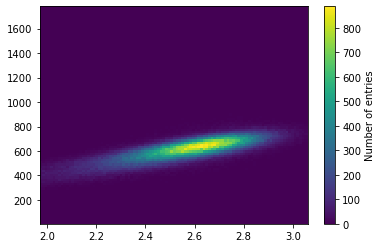

In [147]:
hist_intensity, edges_intensity = np.histogram(peak_vals, bins=100)
show(intensity_hist(hist_intensity, edges_intensity))
plt.hist2d(i_dat[peak_idxs], peak_vals, bins=100)
cb = plt.colorbar()
cb.set_label('Number of entries')
plt.show()
#plt.imshow((hist_intensity, hist))

In [48]:
results = {
    'low_slope': slope,
    'low_intercept': intercept,
    'low_i0': edges[0],
    'high_i0': edges[-1],
    'ave_i0': i_dat.mean(),
    'ave_peak_intensity': integrated_intensity,
    'peak_bin': peak,
    'peak_lower_limit': rad_start,
    'peak_upper_limit': rad_end
}

#After processing
# Peak bin
# low and hi delta_r around peak bin
# Io low bound and high bound
# Average Io
# Average integrated intensity
# slope and intercept of fit of 2D plot
# sigma around line fit
# Run number

print(results)

{'low_slope': 33.236978532885914, 'low_intercept': -23.61277886317087, 'low_intensity': 1.9700377522394774, 'high_intensity': 3.0598240879503464, 'ave_intensity': 2.5633655740767836, 'ave_peak_intensity': 235.07, 'peak_bin': 147, 'peak_lower_limit': 142, 'peak_upper_limit': 152}


NameError: name 'data' is not defined